# The Battle of Neighborhood

## Introduction/Business Problem

####   Opening a business in Toronto is a target of this project. To choose the business type and the location of the business, the location data and characteristic of each region should be investigated. To achieve this goal, the borough and area data would be imported from the Foursquare as we have some experience on that. The below are the list to be done:

#### - Area name and Zip code.
#### - Information about the individual area such as median income, house price, public school score, or residential to commercial ratio.
#### - Data about venues already located in the region/area.

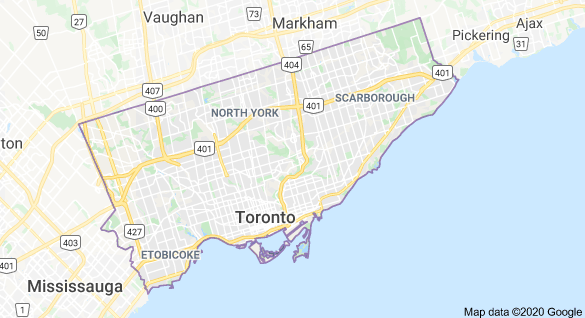

## Data Acquisition

#### As we do for the previous project, the area/borough segmentation can be done according to the data in Wikipedia. Foursquare data will be added once needed to investigate the area venue information

#### Scraping the data from the Wikipedia and creating neighborhood table 

In [4]:
!pip install beautifulsoup4 #install beautifulsoup4

In [5]:
!pip install lxml

In [6]:
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize

import json

import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import lxml.html as lh
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans

In [7]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [8]:
soup = BeautifulSoup(url.content, 'html.parser')

In [9]:
n_table = soup.find('table', class_='wikitable')
df = pd.read_html(str(n_table))
T_df = pd.DataFrame(df[0])

In [10]:
print(T_df.shape)
T_df.head(10)

(287, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Not assigned


In [11]:
dr_df = T_df.drop(T_df[T_df['Borough']=='Not assigned'].index)

In [12]:
dr_df.head(20)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Queen's Park,Not assigned
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [13]:
dr_df[dr_df['Neighbourhood']=='Not assigned']

,Postcode,Borough,Neighbourhood
9,M9A,Queen's Park,Not assigned


In [14]:
n_df = dr_df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(list)

In [15]:
n_df

Postcode  Borough    
M1B       Scarborough                                     [Rouge, Malvern]
M1C       Scarborough             [Highland Creek, Rouge Hill, Port Union]
M1E       Scarborough                  [Guildwood, Morningside, West Hill]
M1G       Scarborough                                             [Woburn]
M1H       Scarborough                                          [Cedarbrae]
                                               ...                        
M9N       York                                                    [Weston]
M9P       Etobicoke                                            [Westmount]
M9R       Etobicoke      [Kingsview Village, Martin Grove Gardens, Rich...
M9V       Etobicoke      [Albion Gardens, Beaumond Heights, Humbergate,...
M9W       Etobicoke                                            [Northwest]
Name: Neighbourhood, Length: 103, dtype: object

In [16]:
n_df = n_df.reset_index()
n_df['Neighbourhood'] = n_df['Neighbourhood'].str.join(', ')
n_df

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


In [17]:
#n_df[n_df[n_df['Neighbourhood']=='Not assigned'].index]
n_df.loc[(n_df.Neighbourhood=='Not assigned'), 'Neighbourhood'] = n_df.loc[(n_df.Neighbourhood=='Not assigned'), 'Borough']

In [18]:
#!pip install geocoder

Tried to use geocode but fail to pull the latitude and longitude. Decide to use the .csv data file.

In [19]:
'''
import geocoder

lat = []
lng = []

for postcode in n_df['Postcode']:
    lat_lng_coords = None
    print(postcode)
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng
        
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])
''' 
        

"\nimport geocoder\n\nlat = []\nlng = []\n\nfor postcode in n_df['Postcode']:\n    lat_lng_coords = None\n    print(postcode)\n    while(lat_lng_coords is None):\n        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))\n        lat_lng_coords = g.latlng\n        \n    lat.append(lat_lng_coords[0])\n    lng.append(lat_lng_coords[1])\n"

Read csv file to get coordinates and use join function to combine the dataframes

In [20]:
n_df

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


In [21]:
coord_df = pd.read_csv('Geospatial_Coordinates.csv')
coord_df.rename(columns={"Postal Code": "Postcode"}, inplace=True)
j_df = n_df
j_df

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


In [22]:
tr_neigh = j_df.join(coord_df.set_index('Postcode'), on='Postcode')

Count the number of the total borough and neighborhoods in the data.

In [23]:
print('The dataframe has {} borough and {} neighborhoods.'.format(len(tr_neigh['Borough'].unique()),tr_neigh.shape[0]))

The dataframe has 11 borough and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude valuese of the neighborhoods in Toronto

In [24]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Import and use folium and visualize at Toronto and its neighborhood in map.

In [25]:
import folium
print('folium imported')

folium imported


In [26]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add neighborhood marker to map
for lat, lng, borough, neighborhood in zip(tr_neigh['Latitude'], tr_neigh['Longitude'], tr_neigh['Borough'], tr_neigh['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#9dc209',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

<img src="toronto.jpg">

#### Explore neighborhood using Foursquare API

In [27]:
CLIENT_ID = 'ODEVQ3PCQWU20LY3DMWPYE1M5IB1XBSF1EXYTNEBY3U20YXW' # your Foursquare ID
CLIENT_SECRET = 'NQSMVMMDYA13YF2BGEGWRX4QHUUALONGFCZEWD3LUCFYPUGU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ODEVQ3PCQWU20LY3DMWPYE1M5IB1XBSF1EXYTNEBY3U20YXW
CLIENT_SECRET:NQSMVMMDYA13YF2BGEGWRX4QHUUALONGFCZEWD3LUCFYPUGU


##### Pick One of the neigborhood in Downtown and explore

In [28]:
tr_neigh.loc[tr_neigh['Borough']=="Downtown Toronto"]

,Postcode,Borough,Neighbourhood,Latitude,Longitude
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
51,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
53,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
54,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
55,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
58,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
59,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752


In [29]:
example_neighbor = tr_neigh.loc[68, 'Neighbourhood']
example_neighbor

'CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara'

In [30]:
ex_nb_lat = tr_neigh.loc[68, 'Latitude']
ex_nb_lon = tr_neigh.loc[68, 'Longitude']

print('Latitude and longitude values of {} are {}, {}'.format(
    example_neighbor, 
    ex_nb_lat, 
    ex_nb_lon))

Latitude and longitude values of CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara are 43.6289467, -79.3944199


In [31]:
LIMIT = 100
radius = 500

url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.\
format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    ex_nb_lat,
    ex_nb_lon,
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ODEVQ3PCQWU20LY3DMWPYE1M5IB1XBSF1EXYTNEBY3U20YXW&client_secret=NQSMVMMDYA13YF2BGEGWRX4QHUUALONGFCZEWD3LUCFYPUGU&v=20180605&ll=43.6289467,-79.3944199&radius=500&limit=100'

Send the GET request to get the venue list in the neiborhood

In [32]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e44c32529ce6a001c7327d1'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 43.6334467045, 'lng': -79.3882145152226},
   'sw': {'lat': 43.6244466955, 'lng': -79.4006252847774}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad8df54f964a520881521e3',
       'name': 'Billy Bishop Toronto City Airport (YTZ) (Billy Bishop Toronto City Airport)',
       'location': {'address': 'Toronto Island',
        'lat': 43.631541287490016,
        'lng': -79.3958684847778,
        'distance': 311,
        'postalCode': 'M5J 1B7',
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
        'country': 'Cana

Borrow a function to get only category name from json file.

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Billy Bishop Toronto City Airport (YTZ) (Billy...,Airport,43.631541,-79.395868
1,Porter Lounge,Airport Lounge,43.630680,-79.395756
2,Toronto Harbour,Harbor / Marina,43.633045,-79.396484
3,Billy Bishop Café,Airport Food Court,43.631132,-79.396139
4,Air Canada Check-In Counter,Airport Terminal,43.631226,-79.395987


In [35]:
nearby_venues.shape

(14, 4)

In [36]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

14 venues were returned by Foursquare.


In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
toronto_venues = getNearbyVenues(names=tr_neigh['Neighbourhood'],
                                   latitudes=tr_neigh['Latitude'],
                                   longitudes=tr_neigh['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [39]:
print("The total number of venues is {}".format(toronto_venues.shape[0]))
toronto_venues.head()

The total number of venues is 4908


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,"Rouge, Malvern",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"Rouge, Malvern",43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Rouge, Malvern",43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store


In [40]:
pd.set_option('display.max_rows', None)
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,46,46,46,46,46,46
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",29,29,29,29,29,29
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",20,20,20,20,20,20
"Alderwood, Long Branch",26,26,26,26,26,26
"Bathurst Manor, Downsview North, Wilson Heights",30,30,30,30,30,30
Bayview Village,14,14,14,14,14,14
"Bedford Park, Lawrence Manor East",40,40,40,40,40,40
Berczy Park,100,100,100,100,100,100


In [41]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 336 uniques categories.


### Analyze Neighborhood Venues Data

In [42]:
# use pandas get_dummies function to create one hot data of venues' categories
toronto_onehot = pd.get_dummies(toronto_venues[["Venue Category"]],prefix="",prefix_sep="")

# add neighborhood column
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
toronto_onehot.shape

(4908, 337)

In [44]:
toronto_nb_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_nb_grouped

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.0000,0.020000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.00
1,Agincourt,0.000000,0.000000,0.000000,0.000000,0.0000,0.021739,0.00,0.00,0.000000,...,0.000000,0.021739,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,...,0.050000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.0000,0.025000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.025000,0.000000,0.000000,0.00
8,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.0000,0.010000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,"Birch Cliff, Cliffside West",0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


#### Present the top 5 most common venues

In [45]:
num_top_venues = 5

for hood in toronto_nb_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_nb_grouped[toronto_nb_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0              Café  0.06
1       Coffee Shop  0.05
2             Hotel  0.05
3           Theater  0.04
4  Sushi Restaurant  0.03


----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.17
1         Shopping Mall  0.09
2                Bakery  0.04
3        Sandwich Place  0.04
4  Caribbean Restaurant  0.04


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0  Chinese Restaurant  0.17
1         Pizza Place  0.07
2        Noodle House  0.07
3              Bakery  0.07
4                Park  0.07


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0           Pizza Place  0.15
1         Grocery Store  0.15
2              Bus Line  0.05
3            Beer Store  0.05
4  Fast Food Restaurant  0.05


----Alderwood, Long Branch----
            venue  freq
0  Discount Store  

In [46]:
np.arange(toronto_nb_grouped.shape[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

Put this infomation into a pandas dataframe

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_nb_grouped['Neighbourhood']

for ind in np.arange(toronto_nb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_nb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)
neighborhoods_venues_sorted.head(100)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Café,Coffee Shop,Hotel,Theater,Restaurant,Sushi Restaurant,Movie Theater,Japanese Restaurant,Thai Restaurant,Bakery
1,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Sandwich Place,Bakery,Shanghai Restaurant,Seafood Restaurant,Bank,Coffee Shop,Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Bakery,Pizza Place,Noodle House,Park,Grocery Store,Fast Food Restaurant,Event Space,Shopping Mall,Shop & Service
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Bus Line,Fried Chicken Joint,Beer Store,Sandwich Place,Caribbean Restaurant,Park,Coffee Shop,Discount Store
4,"Alderwood, Long Branch",Discount Store,Pharmacy,Pizza Place,Sandwich Place,Skating Rink,Donut Shop,Garden Center,Gas Station,Market,Shopping Mall
5,"Bathurst Manor, Downsview North, Wilson Heights",Pizza Place,Coffee Shop,Ski Area,Frozen Yogurt Shop,Sushi Restaurant,Fried Chicken Joint,Supermarket,Mediterranean Restaurant,Bridal Shop,Men's Store
6,Bayview Village,Bank,Gas Station,Japanese Restaurant,Chinese Restaurant,Park,Fast Food Restaurant,Café,Grocery Store,Skating Rink,Trail
7,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Sandwich Place,Pizza Place,Cosmetics Shop,Skating Rink,Bank,Bagel Shop,Bakery
8,Berczy Park,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Beer Bar,Park,Bakery,Italian Restaurant,Steakhouse
9,"Birch Cliff, Cliffside West",Park,Café,Thai Restaurant,Diner,Skating Rink,Gym,Dessert Shop,College Stadium,Restaurant,Gym Pool


Create the grouped data frame without "Neighbourhood" column

In [48]:
toronto_nb_grouped_clustering = toronto_nb_grouped.drop('Neighbourhood', 1)

toronto_nb_grouped_clustering.dropna(inplace=True)
toronto_nb_grouped_clustering.head(30)
toronto_nb_grouped_clustering.shape

(101, 336)

In [49]:
!pip install yellowbrick

     |████████████████████████████████| 389kB 27.1MB/s eta 0:00:01


Using yellowbrick library to find the best k for KMeans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


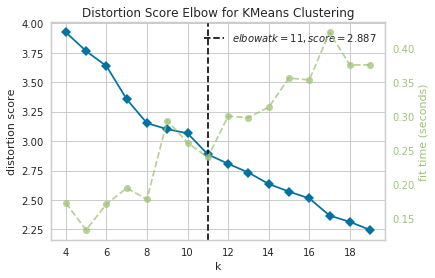

In [58]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer



# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20))

visualizer.fit(toronto_nb_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [51]:
# elbow method from yellow brick library choose 13 for the best K
kclusters = 13

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_nb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([ 1,  9,  9,  5,  5,  5,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,  5,
        1,  5,  1,  1,  1,  1,  5,  5,  5,  2,  1,  1,  1,  1,  2,  1,  1,
        1,  1,  6,  5,  2,  5,  9,  1,  2,  0,  1,  1,  1,  2,  5,  1,  1,
        1,  1,  7,  5,  2, 10, 11,  5,  5,  1,  9,  1,  1,  1,  1,  5,  1,
        1,  1,  4,  5,  1,  2,  1,  2,  1,  8,  1,  1,  5,  3,  1,  1,  1,
        1,  1,  1,  1,  5,  1,  1,  1,  5,  5,  1,  5, 12,  5,  5],
      dtype=int32)

In [52]:
# add clustering labels to the dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = tr_neigh

# merge all related data into toronto_merged data using join.
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')


toronto_merged.head(30)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,8.0,Fast Food Restaurant,Coffee Shop,Trail,Chinese Restaurant,Bakery,Bus Station,Sandwich Place,Paper / Office Supplies Store,Fruit & Vegetable Store,Auto Workshop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,7.0,Burger Joint,Breakfast Spot,Park,Playground,Italian Restaurant,Zoo,Farmers Market,Empanada Restaurant,Ethiopian Restaurant,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,5.0,Pizza Place,Coffee Shop,Fast Food Restaurant,Grocery Store,Fried Chicken Joint,Beer Store,Bank,Sandwich Place,Supermarket,Juice Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,12.0,Park,Coffee Shop,Mobile Phone Shop,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Pharmacy,Zoo,Falafel Restaurant,Elementary School
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,5.0,Bakery,Coffee Shop,Pharmacy,Gas Station,Indian Restaurant,Intersection,Fast Food Restaurant,Chinese Restaurant,Fried Chicken Joint,German Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,5.0,Ice Cream Shop,Sandwich Place,Train Station,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Restaurant,Bowling Alley,Pizza Place,Convenience Store
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,9.0,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Grocery Store,Discount Store,Bank,Pharmacy,Burger Joint,Light Rail Station,Sandwich Place
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,5.0,Intersection,Bus Line,Bakery,Coffee Shop,Park,Pub,Diner,Fast Food Restaurant,Mexican Restaurant,Metro Station
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,5.0,Pizza Place,Beach,Ice Cream Shop,Sports Bar,Pharmacy,Burger Joint,Park,Hardware Store,Cajun / Creole Restaurant,Empanada Restaurant
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,2.0,Park,Café,Thai Restaurant,Diner,Skating Rink,Gym,Dessert Shop,College Stadium,Restaurant,Gym Pool


In [53]:
toronto_merged.dropna()


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,8.0,Fast Food Restaurant,Coffee Shop,Trail,Chinese Restaurant,Bakery,Bus Station,Sandwich Place,Paper / Office Supplies Store,Fruit & Vegetable Store,Auto Workshop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,7.0,Burger Joint,Breakfast Spot,Park,Playground,Italian Restaurant,Zoo,Farmers Market,Empanada Restaurant,Ethiopian Restaurant,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,5.0,Pizza Place,Coffee Shop,Fast Food Restaurant,Grocery Store,Fried Chicken Joint,Beer Store,Bank,Sandwich Place,Supermarket,Juice Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,12.0,Park,Coffee Shop,Mobile Phone Shop,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Pharmacy,Zoo,Falafel Restaurant,Elementary School
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,5.0,Bakery,Coffee Shop,Pharmacy,Gas Station,Indian Restaurant,Intersection,Fast Food Restaurant,Chinese Restaurant,Fried Chicken Joint,German Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,5.0,Ice Cream Shop,Sandwich Place,Train Station,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Restaurant,Bowling Alley,Pizza Place,Convenience Store
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,9.0,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Grocery Store,Discount Store,Bank,Pharmacy,Burger Joint,Light Rail Station,Sandwich Place
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,5.0,Intersection,Bus Line,Bakery,Coffee Shop,Park,Pub,Diner,Fast Food Restaurant,Mexican Restaurant,Metro Station
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,5.0,Pizza Place,Beach,Ice Cream Shop,Sports Bar,Pharmacy,Burger Joint,Park,Hardware Store,Cajun / Creole Restaurant,Empanada Restaurant
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,2.0,Park,Café,Thai Restaurant,Diner,Skating Rink,Gym,Dessert Shop,College Stadium,Restaurant,Gym Pool


In [54]:
toronto_merged.reset_index()
toronto_merged = toronto_merged.drop(index =16)
#toronto_merged["Cluster Labels"]
#toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype(int)

In [55]:
#toronto_merged.head(30)
#toronto_merged["Cluster Labels"]

In [56]:

toronto_merged = toronto_merged.astype({"Cluster Labels": int})

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#5641fd', '#2c7ef7', '#00b5eb', '#2adddd', '#54f6cb', '#80ffb4', '#abf69b', '#d4dd80', '#ffb360', '#ff7e41', '#ff4121', '#ff0000']


<img src="toronto_cluster.jpg">

### Discussion

#### According to the K- mean Clustering and neighborhood analysis, there are some characteristic in some clusters. 
#### For example, restaurants are easily found in Cluster 9 (Lime color)
#### Cluster 10 is featured with park and coffee shop and burger joints are located.

### Conclusion

#### To achieve our goal to open new business, we can peak any cluster 9 for restaurant or cluster 10 for coffee shop. 